# ECE 590, Fall 2019 
## Problem Set 7
 

## Full name: Lidia Azucena Morales Vasquez

## 2. Variational Auto-Encoders (VAEs)

In [17]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Download and prepare the Fashion MNIST data set 
train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

In [18]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super(CVAE, self).__init__()
        # encoder 
        self.fe1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fe2 = nn.Linear(h_dim1, h_dim2)
        self.fe31 = nn.Linear(h_dim2, z_dim)
        self.fe32 = nn.Linear(h_dim2, z_dim)
        # decoder 
        self.fd1 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fd2 = nn.Linear(h_dim2, h_dim1)
        self.fd3 = nn.Linear(h_dim1, x_dim)
    
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fe1(concat_input))
        h = F.relu(self.fe2(h))
        return self.fe31(h), self.fe32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample
    
    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fd1(concat_input))
        h = F.relu(self.fd2(h))
        return F.sigmoid(self.fd3(h))
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [21]:
# loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [22]:
cond_dim = train_loader.dataset.train_labels.unique().size(0)
cvae = CVAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2, c_dim = cond_dim)
optimizer = optim.Adam(cvae.parameters())

def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, cond) in enumerate(train_loader):
        data, cond = data, one_hot(cond, cond_dim)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [23]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, cond in test_loader:
            data, cond = data, one_hot(cond, cond_dim)
            recon, mu, log_var = cvae(data, cond)
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [24]:
for epoch in range(1, 21):
    train(epoch)
    test()

/home/azucena/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 543.298008
Train Epoch: 1 [10000/60000 (17%)]	Loss: 280.269844
Train Epoch: 1 [20000/60000 (33%)]	Loss: 245.671953
Train Epoch: 1 [30000/60000 (50%)]	Loss: 269.283887
Train Epoch: 1 [40000/60000 (67%)]	Loss: 259.812051
Train Epoch: 1 [50000/60000 (83%)]	Loss: 274.189492
====> Epoch: 1 Average loss: 275.0299
====> Test set loss: 259.0813
Train Epoch: 2 [0/60000 (0%)]	Loss: 240.642949
Train Epoch: 2 [10000/60000 (17%)]	Loss: 244.494844
Train Epoch: 2 [20000/60000 (33%)]	Loss: 249.835410
Train Epoch: 2 [30000/60000 (50%)]	Loss: 251.101426
Train Epoch: 2 [40000/60000 (67%)]	Loss: 250.729766
Train Epoch: 2 [50000/60000 (83%)]	Loss: 249.894766
====> Epoch: 2 Average loss: 256.3138
====> Test set loss: 256.7188
Train Epoch: 3 [0/60000 (0%)]	Loss: 243.673301
Train Epoch: 3 [10000/60000 (17%)]	Loss: 254.900273
Train Epoch: 3 [20000/60000 (33%)]	Loss: 247.377031
Train Epoch: 3 [30000/60000 (50%)]	Loss: 257.338125
Train Epoch: 3 [40000/60000 (67%)]	Loss: 249.75

In [32]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

/home/azucena/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


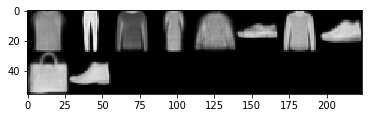

In [33]:
with torch.no_grad():
    z = torch.randn(10, 2)
    c = torch.eye(10)
    sample = cvae.decoder(z, c)
    show(make_grid(sample.view(10, 1, 28, 28), padding=0))

In [ ]:
plt.figure()
show(make_grid(output.reshape(data_size), padding=0))

## 3. Generative Adversial Networks (GANS)

In [1]:
import argparse
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [30]:
os.makedirs("images", exist_ok=True)

n_epochs = 5 # number of epochs of training
batch_size = 64 # size of the batches
lr = 0.0002 # adam: learning rate
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient
latent_dim = 100 # dimensionality of the latent space
img_size = 28 # size of each image dimension
channels = 1 # number of image channels
sample_interval = 500 # interval betwen image samples
img_shape = (channels, img_size, img_size)

In [31]:
class Generator(nn.Module):
    def __init__(self, input_size = 100, alpha = 0.2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size = 7, stride = 1, padding = 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(32, 1, kernel_size = 5, stride = 1, padding = 2),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        return img
    
class Discriminator(nn.Module):
    def __init__(self,alpha = 0.2):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),
            nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha)
            
        )
        self.adv_layer = nn.Sequential(
            nn.Linear(8192, 1), 
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)        
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity


In [33]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), \
             transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.FloatTensor

In [34]:
### ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.randn(imgs.shape[0], latent_dim, 1, 1))
        #z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()) )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/5] [Batch 0/938] [D loss: 0.751830] [G loss: 0.826205]
[Epoch 0/5] [Batch 500/938] [D loss: 0.391729] [G loss: 0.960015]
[Epoch 1/5] [Batch 62/938] [D loss: 0.195187] [G loss: 1.920900]
[Epoch 1/5] [Batch 562/938] [D loss: 0.038059] [G loss: 3.527443]
[Epoch 2/5] [Batch 124/938] [D loss: 0.105996] [G loss: 2.413911]
[Epoch 2/5] [Batch 624/938] [D loss: 0.040094] [G loss: 3.407329]
[Epoch 3/5] [Batch 186/938] [D loss: 0.447664] [G loss: 4.682729]
[Epoch 3/5] [Batch 686/938] [D loss: 0.043818] [G loss: 3.629438]
[Epoch 4/5] [Batch 248/938] [D loss: 0.110964] [G loss: 2.225597]
[Epoch 4/5] [Batch 748/938] [D loss: 0.071536] [G loss: 4.168207]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


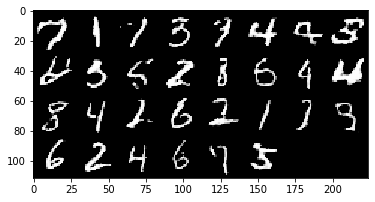

In [55]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(make_grid(gen_imgs.data[:30].view(30, 1, 28, 28), padding=0))

# WDGAN


In [73]:
# Initialize generator and discriminator
wgenerator = Generator()
wdiscriminator = Discriminator()

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Initialize weights
wgenerator.apply(weights_init_normal)
wdiscriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), \
             transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.FloatTensor

In [74]:
# ----------
#  Training
# ----------
n_epochs = 2
batches_done = 0
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = Variable(torch.randn(imgs.shape[0], latent_dim, 1, 1))
        

        # Generate a batch of images
        wgen_imgs = wgenerator(z)
        # Adversarial loss
        loss_G = -torch.mean(discriminator(wgen_imgs))

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Generate a batch of images
        fake_imgs = wgenerator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(wdiscriminator(real_imgs)) + torch.mean(wdiscriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()
            
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item()) )
            save_image(wgen_imgs.data[:25], "images/w%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/2] [Batch 0/938] [D loss: 0.013232] [G loss: -0.499052]
[Epoch 0/2] [Batch 500/938] [D loss: 0.049960] [G loss: -0.496282]
[Epoch 1/2] [Batch 62/938] [D loss: 0.026931] [G loss: -0.528937]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


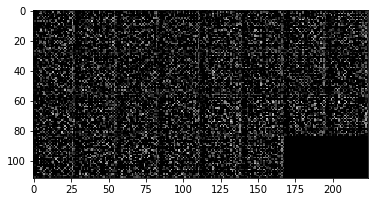

In [75]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(make_grid(wgen_imgs.data[:30].view(30, 1, 28, 28), padding=0))

In [ ]:
# it didn't work !! :(